# Customer Churn Prediction

## Business Problem
To predict customer churns based on the available data so that it will help the business to do the necessary actions to avoid/reduce the churns.


## Evaluation Metric

In this context, a false positive represents unnecessary effort and expenditure in engaging with customers who are not likely to churn. Conversely, a false negative implies missing customers who are at risk of churning, which directly opposes the goal of our analysis.

Our primary focus is on minimizing false negative, even if it means accepting some false positives.

Therefore, ***Recall*** has been chosen as the most appropriate evaluation metric.

## Importing Dependencies

In [1]:
!pip install waterfallcharts

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,accuracy_score
from waterfall_chart import plot as waterfall
from sklearn.ensemble import RandomForestClassifier
import shap

In [3]:

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [4]:
os.listdir('/root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1')


['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [5]:
df = pd.read_csv(f'{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
print(df.iloc[0])

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object


## About the data

1. CustomerID: A unique ID that identifies each customer.

2. Gender: The customer’s gender: Male, Female

3. Senior Citizen: Indicates if the customer is 65 or older: Yes, No

4. Partner: Indicate if the customer has a partner: Yes, No

5. Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

6. Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

7. Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

8. Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

9. Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

10. Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

11. Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

12. Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

13. Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

14. Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

15. Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

16. Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

17. Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

18. Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

19. Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

20. Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

21. Churn: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

It seems there are no null values in the dataset

## Exploratory Data Analysis

Let's drop the customer ID. Also, the total charges is the sum of all the charges received from the customer. Since, we already have monthly charges column, let's drop the 'total charges' column

In [9]:
df.drop(['customerID','TotalCharges'], axis = 1, inplace = True)


In [10]:
num_cols = ['MonthlyCharges', 'tenure']
cat_cols = [x for x in df.columns if x not in num_cols and x !='Churn']
print(num_cols,cat_cols)

['MonthlyCharges', 'tenure'] ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Target (Customer Churn) Analysis

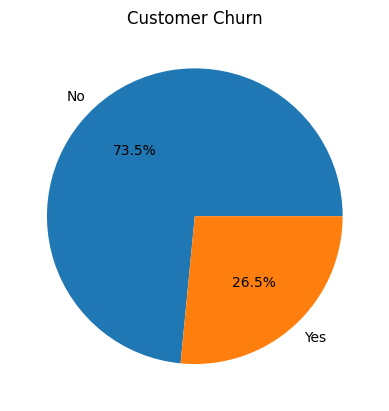

In [11]:
counts = df['Churn'].value_counts()
plt.pie(counts,labels = counts.index,autopct='%1.1f%%')
plt.title('Customer Churn')
plt.show()

## Univariate Analysis - Categorical Features

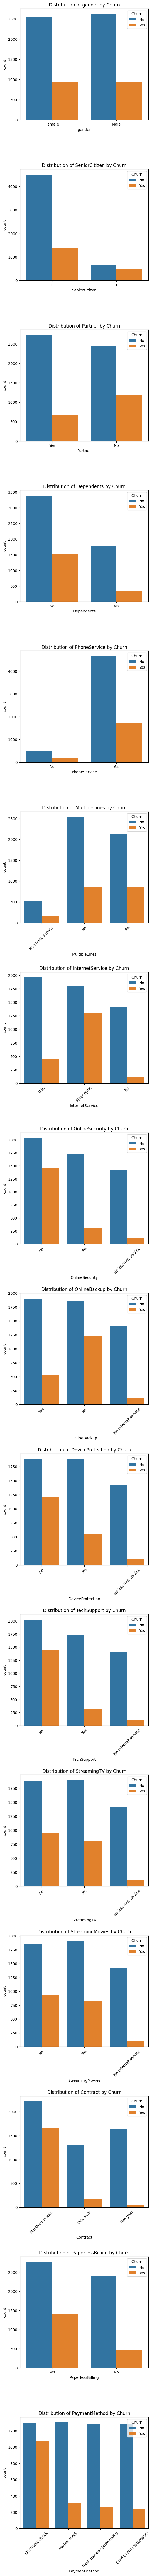

In [12]:
n = len(cat_cols)
fig, axes = plt.subplots(nrows=n, figsize=(6, 6 * n))

for i, column in enumerate(cat_cols):
    sns.countplot(x=column, data=df, hue='Churn', ax=axes[i])
    axes[i].set_title(f"Distribution of {column} by Churn")
    max_label_length = max([len(str(label)) for label in df[column].unique()])
    if max_label_length > 8:
        axes[i].tick_params(axis='x', rotation=45)


plt.tight_layout(pad=2.0)
plt.show()

## Univariate Analysis - Continous features

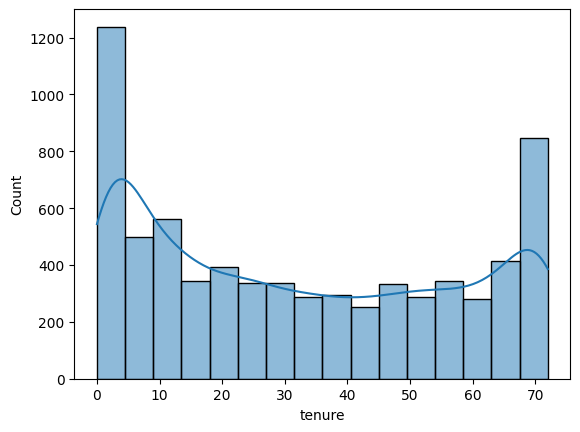

In [13]:
sns.histplot(df['tenure'],kde=True)
plt.show()

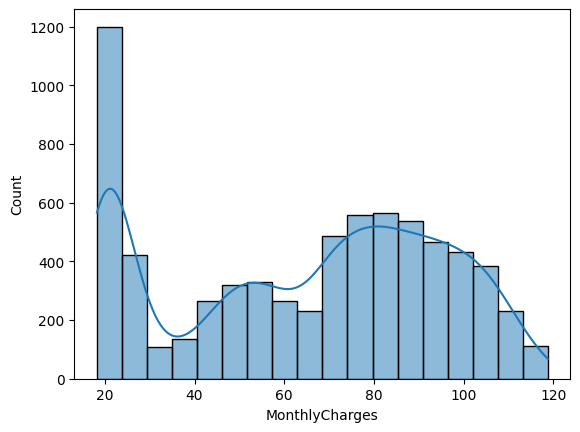

In [14]:
sns.histplot(df['MonthlyCharges'],kde=True)
plt.show()

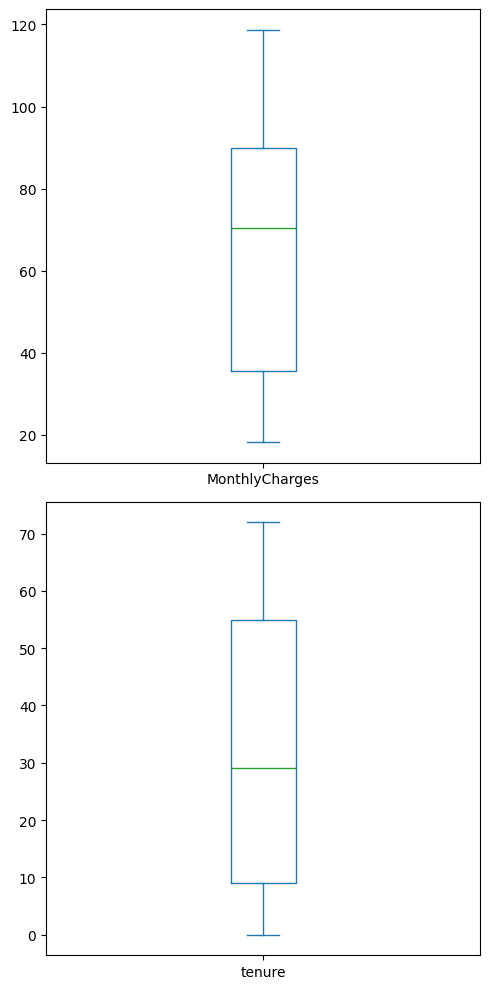

In [15]:
df[num_cols].plot(kind='box', subplots=True, layout=(len(num_cols), 1), figsize= (5, 5 * len(num_cols)))
plt.tight_layout()
plt.show()

## Bivariate Analysis - Continuous to Continuous

Continuous Feature Corre

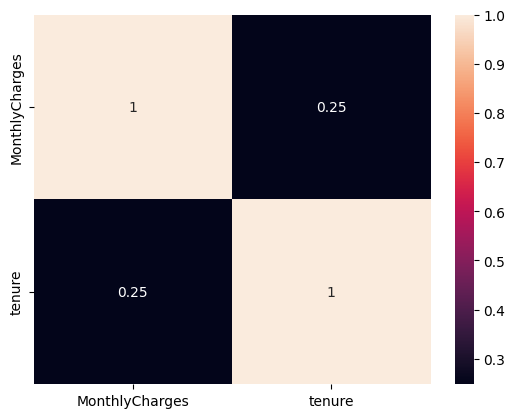

In [16]:
corr_mat = df[num_cols].corr()
sns.heatmap(corr_mat,annot=True)
plt.show()

## Bivariate Analysis - Categorical to Categorical

Categorical feature Independence

In [17]:
def chi_square_test(data,feature_1,feature_2):
  contingency_table = pd.crosstab(data[feature_1],data[feature_2])
  chi2, p, dof, exp = chi2_contingency(contingency_table)
  return chi2, p

In [18]:
cat_corr = []
for i in cat_cols:
  for j in cat_cols:
    if i!=j:
      result=chi_square_test(df,i,j)
      cat_corr.append([i,j,result[0],result[1]])


In [19]:
cat_corr

[['gender', 'SeniorCitizen', 0.015604244282376655, 0.9005892996849594],
 ['gender', 'Partner', 0.016356470128040018, 0.8982341127357725],
 ['gender', 'Dependents', 0.7337079948513788, 0.39168391711610406],
 ['gender', 'PhoneService', 0.2541852775962665, 0.6141433912690947],
 ['gender', 'MultipleLines', 0.6291793687543705, 0.7300883794871589],
 ['gender', 'InternetService', 0.9024775877890381, 0.6368387508139732],
 ['gender', 'OnlineSecurity', 2.0413861525694514, 0.3603451069583911],
 ['gender', 'OnlineBackup', 1.3409496349198287, 0.5114656672930569],
 ['gender', 'DeviceProtection', 0.2560256294083035, 0.8798421041561362],
 ['gender', 'TechSupport', 0.6657182649272054, 0.7168711709191198],
 ['gender', 'StreamingTV', 0.5509185216409054, 0.759223361600868],
 ['gender', 'StreamingMovies', 0.7974498510688455, 0.6711752991499342],
 ['gender', 'Contract', 0.46810729959773456, 0.7913193606321981],
 ['gender', 'PaperlessBilling', 0.9257356216945363, 0.3359734782280932],
 ['gender', 'PaymentMeth

In [20]:
len(cat_cols)

16

In [21]:
cat_rel= pd.DataFrame(cat_corr,columns=['feature_1','feature_2','chi_2','p_value'])

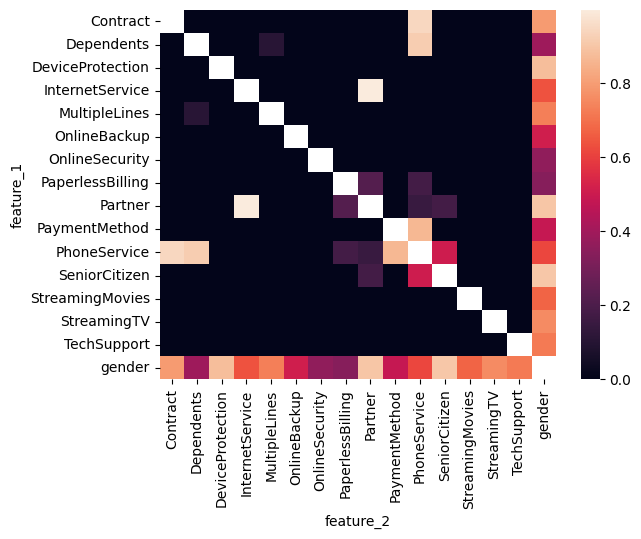

In [22]:
sns.heatmap(cat_rel.pivot(index='feature_1',columns='feature_2',values='p_value'))
plt.show()

Based on the above results, we can conclude that almost all of the categorical are not independent

## Bivariate Analysis - Categorical to Continuous

In [23]:
def kruskal_test(df,cat,num):
  group = [df[num][df[cat]==x] for x in df[cat].unique()]
  result = kruskal(*group)
  return result.pvalue

In [24]:
cat_num_corr = []

for i in cat_cols:
  for j in num_cols:
    cat_num_corr.append([i,j,kruskal_test(df,i,j)])

In [25]:
cat_num_corr

[['gender', 'MonthlyCharges', 0.2490250372948711],
 ['gender', 'tenure', 0.7698616217831195],
 ['SeniorCitizen', 'MonthlyCharges', 7.979832474018463e-77],
 ['SeniorCitizen', 'tenure', 0.11944095655734674],
 ['Partner', 'MonthlyCharges', 8.882777500765359e-20],
 ['Partner', 'tenure', 6.540410446625251e-229],
 ['Dependents', 'MonthlyCharges', 2.708633337072233e-19],
 ['Dependents', 'tenure', 3.5050030697140545e-43],
 ['PhoneService', 'MonthlyCharges', 5.461936572187446e-90],
 ['PhoneService', 'tenure', 0.4765412346888048],
 ['MultipleLines', 'MonthlyCharges', 0.0],
 ['MultipleLines', 'tenure', 4.274912782821728e-187],
 ['InternetService', 'MonthlyCharges', 0.0],
 ['InternetService', 'tenure', 0.0028440148080666945],
 ['OnlineSecurity', 'MonthlyCharges', 0.0],
 ['OnlineSecurity', 'tenure', 2.639045111878211e-174],
 ['OnlineBackup', 'MonthlyCharges', 0.0],
 ['OnlineBackup', 'tenure', 1.054361576758964e-215],
 ['DeviceProtection', 'MonthlyCharges', 0.0],
 ['DeviceProtection', 'tenure', 1.14

In [26]:
cat_num_rel = pd.DataFrame(cat_num_corr,columns =['feature_1','feature_2','p_value'])
cat_num_rel.head()

,feature_1,feature_2,p_value
0,gender,MonthlyCharges,2.490250e-01
1,gender,tenure,7.698616e-01
2,SeniorCitizen,MonthlyCharges,7.979832e-77
3,SeniorCitizen,tenure,1.194410e-01
4,Partner,MonthlyCharges,8.882778e-20


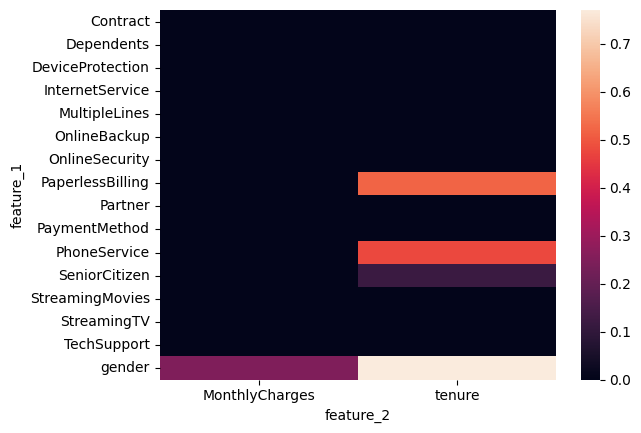

In [27]:
sns.heatmap(cat_num_rel.pivot(index='feature_1',columns='feature_2',values='p_value'))
plt.show()

## Feature Selection

In [28]:
X= df.drop(['Churn'],axis=1)
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40


In [29]:
Y= df['Churn']

In [30]:
Y

,Churn
0,No
1,No
2,Yes
3,No
4,Yes
...,...
7038,No
7039,No
7040,No
7041,Yes


In [31]:
copy_x = X.copy()

In [32]:
label = LabelEncoder()
copy_x[cat_cols] = copy_x[cat_cols].apply(label.fit_transform)

In [33]:
copy_x

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40


In [34]:
mutual=mutual_info_classif(copy_x,Y)

In [35]:
for i in range(len(mutual)):
  print(f'{X.columns[i]} : {mutual[i]}')

gender : 6.553612604065506e-05
SeniorCitizen : 0.013352025941255175
Partner : 0.006613648266848404
Dependents : 0.024129647722414438
tenure : 0.07402721246640276
PhoneService : 0.0011402168671226232
MultipleLines : 0.0012819289926053745
InternetService : 0.0631301926885115
OnlineSecurity : 0.05982683704886416
OnlineBackup : 0.04444299844812627
DeviceProtection : 0.036196421090067155
TechSupport : 0.06868394160175306
StreamingTV : 0.03853458028373735
StreamingMovies : 0.026797647353657972
Contract : 0.10380247955814581
PaperlessBilling : 0.020882124961224546
PaymentMethod : 0.04698450267424703
MonthlyCharges : 0.048729042556423074


We could see that gender, SeniorCitizen, Dependents, Partner,  PhoneService, MultipleLines and PaperlessBilling doesn't have much impact on Churn Prediction.Hence, lets choose the rest of the features.

In [36]:
cat_cols_final = [col for col in cat_cols if col not in ['gender', 'SeniorCitizen', 'Dependents', 'Partner', 'PhoneService', 'MultipleLines', 'PaperlessBilling']]

In [37]:
cat_cols_final

['InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

## Model Selection:

For this customer churn problem, the model should be highly interpretable and so the Business team can identify key features or indicators of churn and proactively work with at-risk customers to prevent it.

Therefore, we canthink of using using the following models which have high to medium level model interpretability:


1.   Logistic Regression
2.   Decision Tree
3.   Random Forest
4.   Naive Bayes



*   Most of the features are highly dependent to each to other due to the nature of the data. Hence, we can avoid Naive Bayes which assumes the features are independent of each other.
*   Since we have a lot of categorical features and the size of the data is not large enough, Decision is very likely to overfit and less reliable

Hence, let's train the data on ***Logistic Regression*** and ***Random Forest*** and choose the best performing model.




## Feature Engineering

## Feature Encoding

In [38]:
one_hot = OneHotEncoder(sparse_output=False)

In [39]:
dummies = pd.DataFrame(one_hot.fit_transform(X[cat_cols_final]))


In [40]:
dummies

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
dummies.shape

(7043, 28)

In [42]:
encoded_cols = one_hot.get_feature_names_out()
encoded_cols

array(['InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype=object)

In [43]:
encoded_cols.shape

(28,)

In [44]:
X_encoded = pd.DataFrame(data=dummies.values,columns = encoded_cols)
X_encoded

,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Scaling

In [45]:
scaler = MinMaxScaler()

In [46]:
X_encoded[num_cols]=scaler.fit_transform(X[num_cols])

In [47]:
X_encoded

,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,tenure
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.115423,0.013889
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.385075,0.472222
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.354229,0.027778
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.239303,0.625000
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.521891,0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.662189,0.333333
7039,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.845274,1.000000
7040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.112935,0.152778
7041,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.558706,0.055556


In [48]:
Y = Y.replace({'Yes': 1,'No':0})
Y

<ipython-input-48-739012c7e961>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = Y.replace({'Yes': 1,'No':0})


,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [49]:
x_train, x_test, y_train, y_test = train_test_split(X_encoded, Y, test_size = 0.2, stratify = Y, random_state = 42)

## Model Training

## Logistic Regression

In [50]:
log_reg = LogisticRegression()

In [51]:
log_param = {'C':[0.1,1,10,100],
             'penalty': ['l2'],
             'solver': ['liblinear','lbfgs'],
             'max_iter': [200,350,500],
             'class_weight': ['balanced']}


In [52]:
grid_search_log = GridSearchCV(estimator = log_reg, param_grid = log_param, cv = 10, scoring = 'recall')

In [53]:
grid_search_log.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'max_iter': [200, 350, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='recall')

In [54]:
grid_search_log.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [55]:
best_log_reg = grid_search_log.best_estimator_

In [56]:
y_pred_log = best_log_reg.predict(x_test)

In [57]:
print(f'Recall: {recall_score(y_test,y_pred_log)}')
print(f'Precision: {precision_score(y_test,y_pred_log)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_log)}')
print(f'F1 Score: {f1_score(y_test,y_pred_log)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test,y_pred_log)}')

Recall: 0.7887700534759359
Precision: 0.506872852233677
Accuracy: 0.7402413058907026
F1 Score: 0.6171548117154811
ROC-AUC Score: 0.7557376837427987


In [58]:
coefficients = best_log_reg.coef_[0]
log_odds = np.exp(coefficients)

In [59]:
for i in range(len(log_odds)):
  print(X_encoded.columns[i],log_odds[i])

InternetService_DSL 0.5974613490899353
InternetService_Fiber optic 2.042959483561826
InternetService_No 0.8391451942461596
OnlineSecurity_No 1.3403488988960084
OnlineSecurity_No internet service 0.8391451942461596
OnlineSecurity_Yes 0.9106504509317807
OnlineBackup_No 1.1364455585621076
OnlineBackup_No internet service 0.8391451942461596
OnlineBackup_Yes 1.074041180406246
DeviceProtection_No 1.0802404246509618
DeviceProtection_No internet service 0.8391451942461596
DeviceProtection_Yes 1.1299237663497355
TechSupport_No 1.2862305873815474
TechSupport_No internet service 0.8391451942461596
TechSupport_Yes 0.9489661816162772
StreamingTV_No 0.8977017580457921
StreamingTV_No internet service 0.8391451942461596
StreamingTV_Yes 1.3596824538270862
StreamingMovies_No 0.8817032103054324
StreamingMovies_No internet service 0.8391451942461596
StreamingMovies_Yes 1.3843539582458417
Contract_Month-to-month 2.2217647253919126
Contract_One year 0.9751870609122062
Contract_Two year 0.4727381845555734
Pa

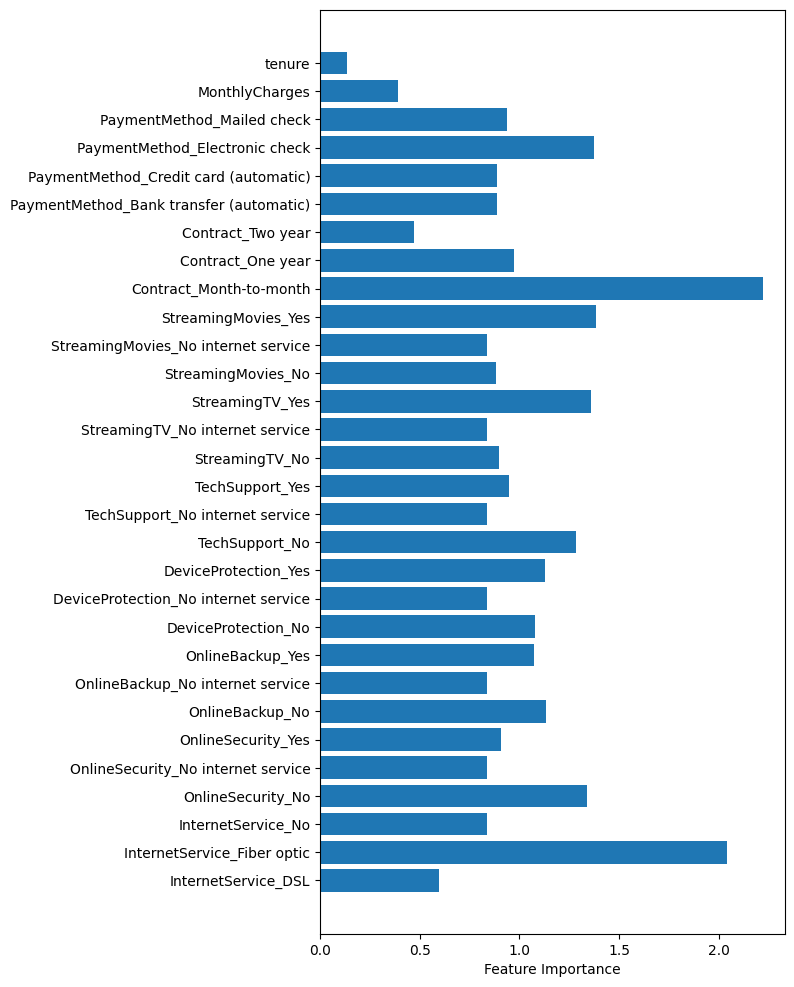

In [60]:

plt.figure(figsize = (6,12))
plt.barh(range(len(log_odds)),log_odds)
plt.yticks(range(len(log_odds)),X_encoded.columns)
plt.xlabel('Feature Importance')
plt.show()

/usr/local/lib/python3.10/dist-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/usr/local/lib/python3.10/dist-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


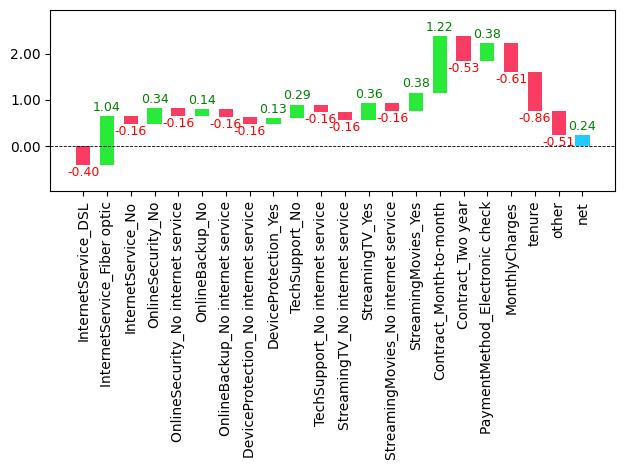

In [61]:
waterfall(X_encoded.columns, log_odds-1, threshold = 0.1,
          rotation_value=90, formatting='{:,.2f}');

## Random Forest

In [62]:
rf = RandomForestClassifier(random_state = 42)

In [63]:
param_rf = {
    'n_estimators': [100,200],
    'max_depth': [10, 15],
    'min_samples_split': [5,8],
    'min_samples_leaf': [3,4],
    'max_features': ['log2','sqrt']
}

In [64]:
grid_rf = GridSearchCV(estimator = rf, param_grid = param_rf, cv = 10, scoring = 'recall')

In [65]:
grid_rf.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [5, 8],
                         'n_estimators': [100, 200]},
             scoring='recall')

In [66]:
best_rf = grid_rf.best_estimator_

In [67]:
y_pred_rf = best_rf.predict(x_test)

In [68]:
y_pred_rf

array([0, 1, 0, ..., 0, 0, 0])

In [69]:
print(f'Recall: {recall_score(y_test,y_pred_rf)}')
print(f'Precision: {precision_score(y_test,y_pred_rf)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_rf)}')
print(f'F1 Score: {f1_score(y_test,y_pred_rf)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test,y_pred_rf)}')

Recall: 0.5240641711229946
Precision: 0.6242038216560509
Accuracy: 0.7899219304471257
F1 Score: 0.5697674418604651
ROC-AUC Score: 0.7050272546436229


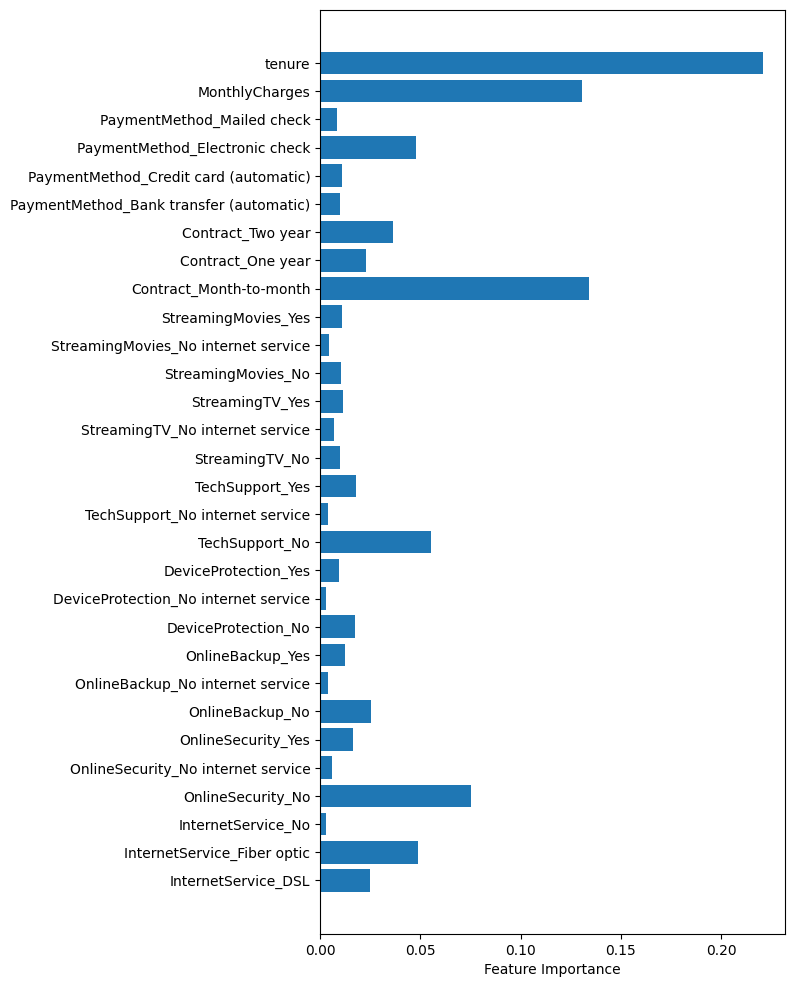

In [70]:
feature_importance = best_rf.feature_importances_
plt.figure(figsize = (6,12))
plt.barh(range(len(feature_importance)),feature_importance)
plt.yticks(range(len(feature_importance)),X_encoded.columns)
plt.xlabel('Feature Importance')
plt.show()


## Final Model Selection



*   It seems Logistic Regression has performed a lot better with 78% Recall score
comparing with Random Forest which has scored 52%. Rest of the metrics are also fairly close.
*   Hence, we can select logistic regression as the final model for churn Prediction.






Let's try to interpret the model deeper to how change in features affect the Churn prediction as it will help the business teams make precautions to avoid Churns.

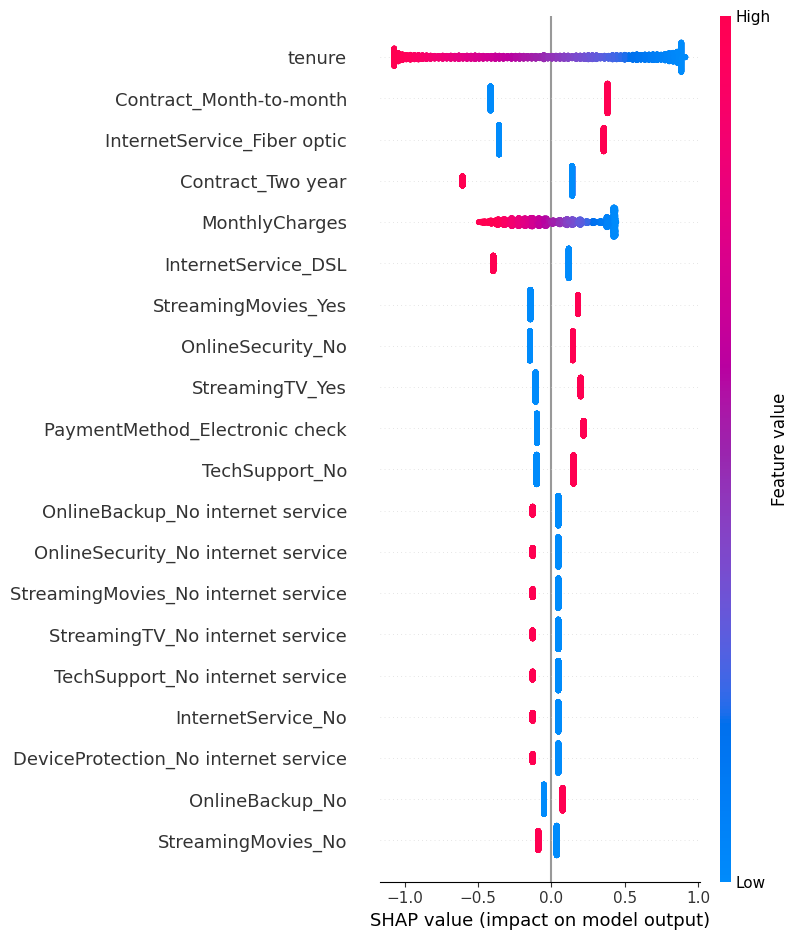

In [71]:
explainer = shap.LinearExplainer(best_log_reg,x_train)
shap_values = explainer(x_train)
shap.summary_plot(shap_values,x_train)

###Feature Impact:

1. tenure: Customers with higher tenure (red dots on the negative side) are less likely to churn, while low tenure (blue dots on the positive side) increases churn probability.
2. Contract_Month-to-month: Having a month-to-month contract strongly increases churn (positive SHAP value), while other contracts (e.g., 2-year contracts) are associated with lower churn.
3. InternetService_Fiber optic: Customers using Fiber optic service are likely to churn, while other types (DSL) are not likely to churn.

## Future Scope:

We can collect more data to enhance the churn analysis and prediction such as:

1. The setiment of customer from the recent interaction with customer support
2. Frequency of service interruptions if any
3. Recent change in service charges, if any
4. Recent locality change
